In [1]:
# Import all the things

import json
import pandas as pd
import numpy as np
import datetime
import acquire
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords
import prepare
import wrangle 
import re
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import nltk

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## Initial Planning Analysis

In [2]:
# # read in primary utterances csv for dataframe
# df = pd.read_csv('./utterances.csv')
# df.head()

In [3]:
# # find utterance count per episode
# df.episode.value_counts()

In [4]:
# # find utterance count per episode
# test = df.episode.value_counts() < 2
# test.sum()

In [5]:
# # pull in episodes df
# ep_df = pd.read_csv('./episodes.csv')
# ep_df.head()

In [6]:
# # check episode content to see if it matches episode id
# df[df.episode == 92554].utterance.to_list()

In [7]:
# # check ep_df.id = df.episode
# ep_df[ep_df.id == 92554].title.to_list()

### Initial takeaways
There are episodes with one utterance, showing less interview setting and more reporting.

ep_df.id == df.episode

### Acquire


In [8]:
# df = pd.read_csv('./utterances.csv')
# ep_df = pd.read_csv('./episodes.csv')


In [9]:
# df['speaker'] = df.speaker.str.lower()
# df['program'] = df.program.str.lower()
# df['title'] = df.title.str.lower()

In [10]:
# # joining utterances df ('df') and episodes on 'id'
# joined_df = pd.merge(df, ep_df, left_on = 'episode', right_on='id', how = 'inner')
# joined_df.drop(columns = ['id'], inplace=True)
# joined_df.rename(columns={'episode':'episode_id'}, inplace = True)

In [11]:
# joined_df['is_host'] = joined_df.speaker.str.contains(r'\W*(host)\W*')

In [12]:
# df = acquire.get_df()

In [156]:
df['speaker'] = df.speaker.str.replace(r'\([^)]*\)','', regex=True)
df['speaker'] = df.speaker.str.replace(r'host','', regex=True)
df['speaker'] = df.speaker.str.replace(r'[^a-z0-9\s\.]','', regex=True)

In [157]:
df

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,True,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,True,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12
...,...,...,...,...,...,...,...,...,...,...,...
3199851,69759,29,ray magliozzi,(Laughter).,all things considered,should you warm up your car before driving to ...,False,laughter .,laughter .,0.4939,2017-12-29
3199852,69759,30,robert siegel,It sounds like very good advice.,all things considered,should you warm up your car before driving to ...,True,it sounds like very good advice .,it sound like very good advice .,0.6901,2017-12-29
3199853,69759,31,ray magliozzi,"Oh, I don't know about that.",all things considered,should you warm up your car before driving to ...,False,"oh , i don t know about that .","oh , i don t know about that .",0.0000,2017-12-29
3199855,69759,33,robert siegel,"Ray Magliozzi, co-host of the longtime NPR pro...",all things considered,should you warm up your car before driving to ...,True,"ray magliozzi , co host of the longtime npr pr...","ray magliozzi , co host of the longtime npr pr...",0.7906,2017-12-29


In [158]:
host_map = pd.read_json('host-map.json')
host_map = host_map.T
hosts = host_map.name.to_list()

In [159]:
df['is_host'] = df.speaker.isin(hosts)

In [160]:
df

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date
0,57264,9,ms. loren mooney,"It's a 2,200-mile race. To give some sense of ...",talk of the nation,how to watch the tour de france,False,"it s a 2,200 mile race. to give some sense of ...","it s a 2,200 mile race. to give some sense of ...",0.0000,2010-07-12
1,57264,10,ms. loren mooney,So for a top competitor like Lance to try to m...,talk of the nation,how to watch the tour de france,False,so for a top competitor like lance to try to m...,so for a top competitor like lance to try to m...,0.9346,2010-07-12
2,57264,11,neal conan,"So in every team, presumably there's one star,...",talk of the nation,how to watch the tour de france,False,"so in every team , presumably there s one star...","so in every team , presumably there s one star...",0.7096,2010-07-12
3,57264,12,ms. loren mooney,That's right. Each team has nine riders. And w...,talk of the nation,how to watch the tour de france,False,that s right. each team has nine riders. and w...,that s right. each team ha nine riders. and wh...,0.9274,2010-07-12
4,57264,13,neal conan,"So slipstream, this is like drafting in car ra...",talk of the nation,how to watch the tour de france,False,"so slipstream , this is like drafting in car r...","so slipstream , this is like drafting in car r...",0.3612,2010-07-12
...,...,...,...,...,...,...,...,...,...,...,...
3199851,69759,29,ray magliozzi,(Laughter).,all things considered,should you warm up your car before driving to ...,False,laughter .,laughter .,0.4939,2017-12-29
3199852,69759,30,robert siegel,It sounds like very good advice.,all things considered,should you warm up your car before driving to ...,False,it sounds like very good advice .,it sound like very good advice .,0.6901,2017-12-29
3199853,69759,31,ray magliozzi,"Oh, I don't know about that.",all things considered,should you warm up your car before driving to ...,False,"oh , i don t know about that .","oh , i don t know about that .",0.0000,2017-12-29
3199855,69759,33,robert siegel,"Ray Magliozzi, co-host of the longtime NPR pro...",all things considered,should you warm up your car before driving to ...,False,"ray magliozzi , co host of the longtime npr pr...","ray magliozzi , co host of the longtime npr pr...",0.7906,2017-12-29


## Preparation

- nulls
- duplicates
- create sentiment score
- use prep functions
- keep some punctuation
- split
- date to datetime

In [13]:

# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()
# # create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']
# # drop duplicates
# df.drop_duplicates(inplace = True)
# # drop nulls
# df.dropna(inplace=True)
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)
# # vader sentiment analysis
# sia = nltk.sentiment.SentimentIntensityAnalyzer()
# df['vader'] = df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# # date column to datetime
# df['date'] = pd.to_datetime(df.episode_date)
# # cutoff dates prior to 2005 due to low observation count
# df = df[df.date > '2005']
# # double check drop nulls
# df.dropna(inplace = True)

In [14]:
# # obtain top 10 hosts
# hosts_to_keep = df[df.is_host == True].speaker.value_counts().head(10).index.to_list()
# # create host df
# hosts_df = df[df.speaker.isin(hosts_to_keep)]
# # get episode_id of top 10 hosts
# top_host_episodes = hosts_df.episode_id.value_counts().index.to_list()


In [15]:
# create dataframe with mask of episodes with top hosts
# df = df[df.episode_id.isin(top_host_episodes)]

In [16]:
# # drop nulls
# df.dropna(inplace=True)

In [17]:
# drop duplicates
# df.drop_duplicates(inplace = True)

In [18]:
# # remove rows without speaker (sound effects)
# df = df[df.speaker!='_NO_SPEAKER']

In [19]:
# # remove rows with foreign languages spoken
# df = df[df.utterance!='(Foreign language spoken)']


In [20]:
# # create clean column
# df['clean'] = [tokenize(basic_clean(u)) for u in df.utterance]


In [21]:
# # create lemmatized column
# df['lemmatized'] = df['clean'].apply(tokenize).apply(lemmatize)


In [22]:
# df.head()

In [23]:
# df = wrangle.get_npr_data()

## JOSH
- Are there words that are said more frequently by hosts? By time of day? By category?
What host(s) say(s) the most words?

In [155]:
df = wrangle.get_npr_data()

The df has 1889857 rows and 12 columns.


In [26]:
# df['lemmatized'] = df.lemmatized.astype(str)
# df['clean'] = df.clean.astype(str)

In [27]:
df = df.astype({'clean':str,'lemmatized':str})

In [37]:
df['message_length'] = df.clean.apply(len)
df['word_count'] = df.clean.apply(basic_clean).apply(str.split).apply(len)

In [38]:
train, validate, test = wrangle.split_data(df)

In [92]:
df[df.is_host == True].speaker.value_counts().index.to_list()

['neal conan, host',
 'ira flatow, host',
 'steve inskeep, host',
 'robert siegel, host',
 'melissa block, host',
 'renee montagne, host',
 'farai chideya, host',
 'scott simon, host',
 'rachel martin, host',
 'david greene, host',
 'michele norris, host',
 'audie cornish, host',
 'noel king, host',
 'linda wertheimer, host',
 'ari shapiro, host',
 'mary louise kelly, host',
 'guy raz, host',
 'deborah amos, host',
 'madeleine brand, host',
 'lynn neary, host',
 'liane hansen, host',
 'kelly mcevers, host',
 'john ydstie, host',
 'ed gordon, host',
 'ailsa chang, host',
 'don gonyea, host',
 'tony cox, host',
 'mr. mike rowe (host, "dirty jobs)',
 'flora lichtman, host',
 'rebecca roberts, host',
 'ira glass (host)',
 'mr. jeff obafemi carr (radio host, freestyle)',
 'mr. jeff obafemi carr (host, freestyle)',
 'ms. nigella lawson (host/author, "nigella express")',
 'susan stamberg, host',
 'mr. jeff obafemi carr (host, "freestyle")',
 'mr. jeff obafemi carr (host, “freestyle”)',
 'mr. 

### Hosts

In [40]:
# df of hosts
host_df = df[df.is_host==True]
# hosts with most interviews
hosts_with_the_most = host_df.speaker.value_counts().head(10).index.to_list()

In [41]:
# aggregate utterances by the speakers that are in top 10 hosts
host_words = train[train.speaker.isin(hosts_with_the_most)].groupby('speaker')['clean'].agg(lambda col: ' '.join(col))

In [57]:
def string_cleaning(s):
    '''
    Function to remove punctuation and numbers from word frequencies for hosts.
    '''
    # remove special characters
    s = re.sub(r"[^a-z'\s]", '', s)

    return s

In [58]:
host_words = host_words.apply(string_cleaning).apply(remove_stopwords)

In [59]:
# create word frequencies for each host
greene_freq = pd.Series(host_words['david greene, host'].split()).value_counts()
martin_freq = pd.Series(host_words['rachel martin, host'].split()).value_counts()
simon_freq = pd.Series(host_words['scott simon, host'].split()).value_counts()
chideya_freq = pd.Series(host_words['farai chideya, host'].split()).value_counts()
montagne_freq = pd.Series(host_words['renee montagne, host'].split()).value_counts()
block_freq = pd.Series(host_words['melissa block, host'].split()).value_counts()
siegel_freq = pd.Series(host_words['robert siegel, host'].split()).value_counts()
inskeep_freq = pd.Series(host_words['steve inskeep, host'].split()).value_counts()
flatow_freq = pd.Series(host_words['ira flatow, host'].split()).value_counts()
conan_freq = pd.Series(host_words['neal conan, host'].split()).value_counts()

In [60]:
# create word counts dataframe of all host word frequencies
word_counts = pd.concat([conan_freq, flatow_freq, inskeep_freq, siegel_freq, block_freq, montagne_freq, chideya_freq, simon_freq, martin_freq, greene_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['conan', 'flatow', 'inskeep', 'siegel', 'block', 'montagne', 'chideya', 'simon', 'martin', 'greene']
word_counts

,conan,flatow,inskeep,siegel,block,montagne,chideya,simon,martin,greene
us,39584,5614,2824,4716,2673,3294,3200,5038,2991,2054
talk,18268,3861,923,552,800,448,996,419,522,564
much,14374,1225,2217,1425,1340,1435,1282,2542,1498,801
well,14351,2572,1559,2417,1505,1096,2121,905,540,1290
let,13896,3366,1610,622,617,541,1541,682,749,972
...,...,...,...,...,...,...,...,...,...,...
kiki,0,0,0,0,0,0,0,0,0,1
chelan,0,0,0,0,0,0,0,0,0,1
leathers,0,0,0,0,0,0,0,0,0,1
goldinauctionscom,0,0,0,0,0,0,0,0,0,1


In [87]:
# create dictionary for word clouds
word_lists = {'conan':host_words['neal conan, host'], 
'flatow':host_words['ira flatow, host'], 
'inskeep': host_words['steve inskeep, host'], 
'siegel':host_words['robert siegel, host'], 
'block':host_words['melissa block, host'], 
'montagne':host_words['renee montagne, host'], 
'chideya':host_words['farai chideya, host'], 
'simon':host_words['scott simon, host'], 
'martin':host_words['rachel martin, host'], 
'greene':host_words['david greene, host']}

(-0.5, 799.5, 599.5, -0.5)

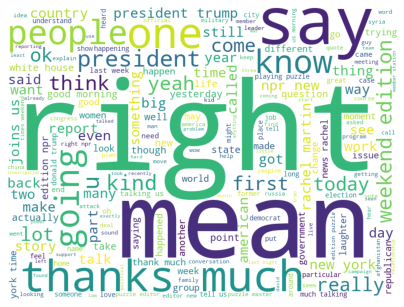

In [85]:
plt.figure(figsize=(7,7))
img = WordCloud(background_color='white', width=800, height=600).generate(host_words[5])
plt.imshow(img)
plt.axis('off')
# plt.title(f'{host_words[5]}')

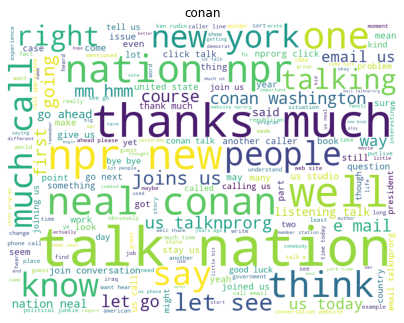

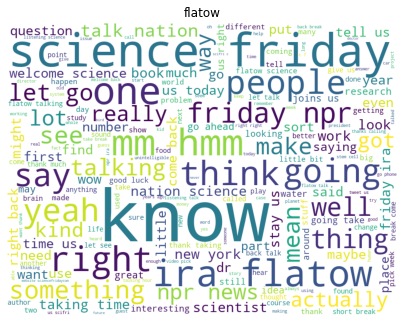

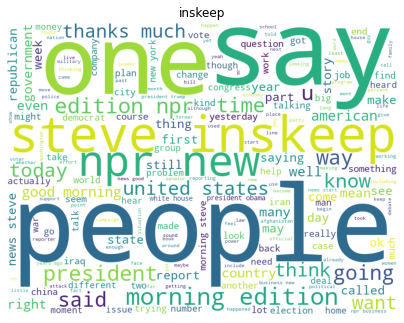

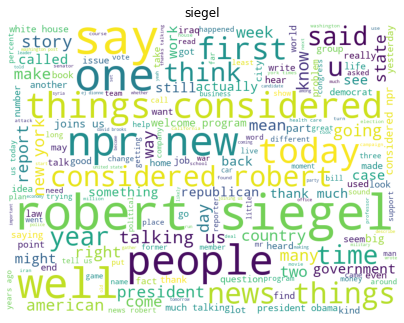

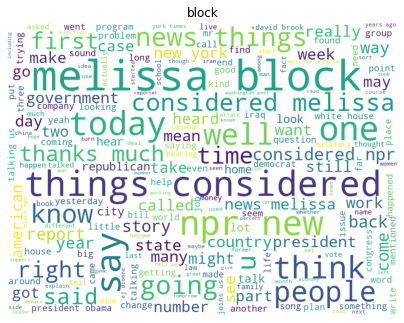

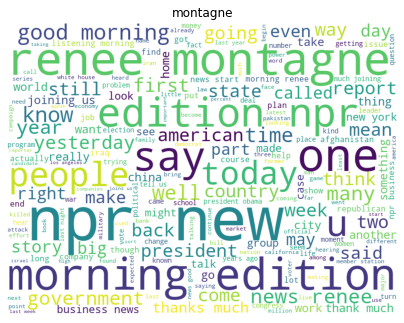

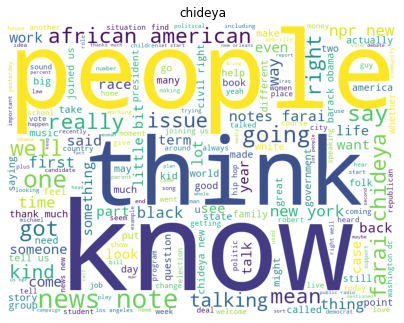

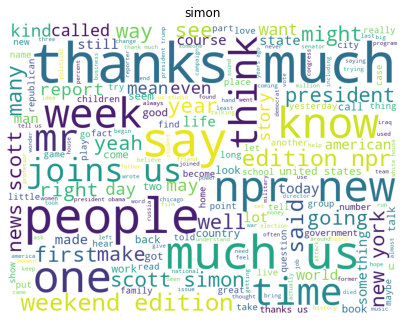

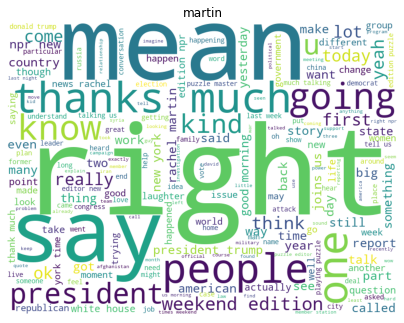

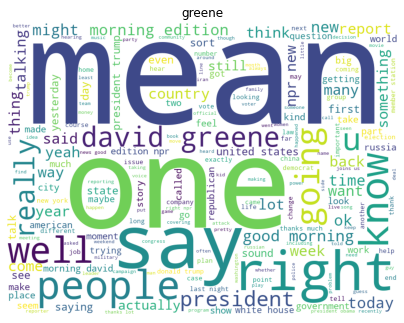

In [89]:
# word clouds
for h in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[h])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{h}')
    plt.show()

In [48]:
# train['message_length'] = train.clean.apply(len)
# train['word_count'] = train.clean.apply(basic_clean).apply(str.split).apply(len)

# validate['message_length'] = validate.clean.apply(len)
# validate['word_count'] = validate.clean.apply(basic_clean).apply(str.split).apply(len)

# test['message_length'] = test.clean.apply(len)
# test['word_count'] = test.clean.apply(basic_clean).apply(str.split).apply(len)

# train.head()

,episode_id,episode_order,speaker,utterance,program,title,is_host,clean,lemmatized,vader,date,message_length,word_count
161541,118827,37,patti neighmond,...to the second house call.,morning edition,after-hours doctor calls save holland money,False,... to the second house call .,... to the second house call .,0.0000,2008-07-17,30,7
93034,120125,11,scott horsley,"But Vice President Biden, who oversees the pro...",all things considered,"as obama touts stimulus, americans are skeptical",False,"but vice president biden , who oversees the pr...","but vice president biden , who oversees the pr...",0.0000,2010-06-18,130,25
2111715,66141,43,"neal conan, host",They weren't accountable to their children.,talk of the nation,is barack obama the new black role model?,True,they weren t accountable to their children .,they weren t accountable to their child .,0.0000,2009-02-02,44,8
98286,103967,9,"michele kelemen, byline","Neumann was ambassador to many trouble spots, ...",all things considered,ambassadors question decision to close mideast...,False,"neumann was ambassador to many trouble spots ,...","neumann wa ambassador to many trouble spot , i...",-0.5187,2013-08-05,203,36
1406249,122930,19,pam fessler,"He says in 1992, for example, then-Arkansas Go...",morning edition,senators lobby for regional primary system,False,"he says in 1992 , for example , then arkansas ...","he say in 1992 , for example , then arkansas g...",0.8126,2007-09-20,314,55


In [ ]:
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').message_length.mean())
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.mean())
print(train[train.speaker.isin(hosts_with_the_most)].groupby('speaker').word_count.sum())

speaker
david greene, host      178.760259
farai chideya, host     190.173800
ira flatow, host        122.776262
melissa block, host     164.656432
neal conan, host        148.899234
rachel martin, host     157.298332
renee montagne, host    171.041212
robert siegel, host     174.635140
scott simon, host       181.393062
steve inskeep, host     168.979687
Name: message_length, dtype: float64
speaker
david greene, host      34.854750
farai chideya, host     37.695985
ira flatow, host        25.493543
melissa block, host     31.889422
neal conan, host        30.021699
rachel martin, host     30.763272
renee montagne, host    32.494347
robert siegel, host     33.524589
scott simon, host       35.161734
steve inskeep, host     32.412296
Name: word_count, dtype: float64
speaker
david greene, host       555515
farai chideya, host      768018
ira flatow, host        1044292
melissa block, host      711453
neal conan, host        4293223
rachel martin, host      523837
renee montagne, host    

In [ ]:
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).message_length.sum()

speaker              episode_id
david greene, host   777           1742
                     780            189
                     800            667
                     802            708
                     804            489
                                   ... 
steve inskeep, host  133180          18
                     133182          23
                     133184         453
                     135547         365
                     138265        1624
Name: message_length, Length: 56725, dtype: int64

In [56]:
train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).word_count.sum()

speaker              episode_id
david greene, host   777           335
                     780            38
                     800           121
                     802           141
                     804            91
                                  ... 
steve inskeep, host  133180          5
                     133182          6
                     133184         80
                     135547         69
                     138265        311
Name: word_count, Length: 56725, dtype: int64

In [54]:
# train[train.speaker.isin(hosts_with_the_most)].groupby(['speaker','episode_id']).word_count.mean()

speaker              episode_id
david greene, host   777           23.928571
                     780           19.000000
                     800           60.500000
                     802           23.500000
                     804           91.000000
                                     ...    
steve inskeep, host  133180         5.000000
                     133182         6.000000
                     133184        26.666667
                     135547        34.500000
                     138265        28.272727
Name: word_count, Length: 56725, dtype: float64

In [ ]:
for host in word_counts.columns.to_list():
    print(language)
    print(pd.DataFrame(word_counts.sort_values(language, ascending = False).head(20)))
    print('\n\n\n')